### 목차  
`[학습 속도 최적화 기법]`  
1.1. 자동 혼합 정밀도 (Automatic Mixed Precision, AMP) 학습  
1.2. 병목 지점 (Bottleneck) 찾고 수정하기 (Profiler 활용)  
1.3. 데이터 로더 (DataLoader) 속도 향상  
1.4. 정적 컴파일 (Static Compilation)  
1.5. 분산 학습 (Distributed Training)   
&emsp;1.5.1. 단일 머신에서의 데이터 병렬 처리 (Data Parallelism)  
&emsp;1.5.2. 다중 머신에서의 분산 데이터 병렬 처리 (Distributed Data Parallel, DDP)  
&emsp;1.5.3. 그래디언트 누적 (Gradient Accumulation)  
1.6. 작업 특화 라이브러리 활용  
&emsp;1.6.1. PyTorch Lightning  
&emsp;1.6.2. NVIDIA Apex  
&emsp;1.6.3. Microsoft DeepSpeed  
1.7. 모델 특화 최적화  
&emsp;1.7.1. 사전 학습된 모델 Fine-tuning  
&emsp;1.7.2. 가지치기 (Pruning) 및 양자화 (Quantization)를 통한 모델 크기 축소  
1.8. cuDNN 및 GPU 설정  
&emsp;1.8.1. cuDNN 자동 튜너 활성화  
&emsp;1.8.2. 결정적 (Deterministic) 모드 비활성화  
&emsp;1.8.3. 비동기 (Non-Blocking) 데이터 전송 사용  

`[메모리 사용량 최적화 기법]`  
2.1. 자동 혼합 정밀도 (Automatic Mixed Precision, AMP) 학습  
2.2. 저정밀도 (Lower-Precision) 학습 (BF16)  
2.3. 그래디언트 체크포인팅 (Gradient Checkpointing)  
2.4. 그래디언트 누적 (Gradient Accumulation)을 이용한 배치 크기 감소  
2.5. 텐서 샤딩 (Tensor Sharding) 및 분산 학습 (Distributed Training)  
2.6. 효율적인 데이터 로딩  
2.7. In-Place 연산 활용  
2.8. 활성화 함수 및 파라미터 오프로딩 (Offloading)  
2.9. 더 가벼운 옵티마이저 사용  
2.10. 고급 기법  
&emsp;2.10.1. 메모리 프로파일링 및 캐시 관리  
&emsp;2.10.2. TorchScript를 이용한 JIT 컴파일  
&emsp;2.10.3. 사용자 정의 커널 융합 (Custom Kernel Fusion)  
&emsp;2.10.4. torch.compile()을 이용한 동적 메모리 할당 최적화  

# 1. 학습 속도 최적화 기법

## 1.1 자동 혼합 정밀도(Automatic Mixed Precision)

- 혼합 정밀도 학습은 32비트 부동 소수점 연산과 16비트 부동 소수점 연산을 혼합하여 사용하는 학습 방식으로, 이를 통해 메모리 사용량을 줄이고 연산속도를 향상시킬 수 있음
- torch의 torch.amp('cuda')와 같은 방식으로 쉽게 구현 가능
- 이 과정에서 일부 모델의 수치적 안정성 문제가 발생할 수 있으며, 성능 하락으로까지 이어질 수 있기에 이럴 경우 normalizer 등에는 명시적으로 32비트 연산을 하는 식으로 적용할 수 있음

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# 간단한 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(nn.Linear(1000, 100), 
                                    nn.ReLU(),
                                    nn.Linear(100, 1))

    def forward(self, x):
        return self.layers(x)

# 가짜 데이터 생성
inputs = torch.randn(1000, 1000).cuda()
labels = torch.randn(1000, 1).cuda()
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=32)

model_fp32 = SimpleModel().cuda()
optimizer_fp32 = optim.Adam(model_fp32.parameters(), lr=0.01)
criterion = nn.MSELoss()

model_amp = SimpleModel().cuda()
optimizer_amp = optim.Adam(model_amp.parameters(), lr=0.01)
scaler = torch.amp.GradScaler('cuda')

# FP32 학습 성능 측정
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        optimizer_fp32.zero_grad()
        outputs = model_fp32(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_fp32.step()
end_time = time.time()
time_fp32 = end_time - start_time
print(f"FP32 학습 시간: {time_fp32:.4f} 초")

# AMP 학습 성능 측정
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        optimizer_amp.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model_amp(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer_amp)
        scaler.update()
end_time = time.time()
time_amp = end_time - start_time
print(f"AMP 학습 시간: {time_amp:.4f} 초")

print(f"AMP 사용 시 {time_fp32 / time_amp:.2f}배 속도 향상")

FP32 학습 시간: 0.2911 초
AMP 학습 시간: 0.2287 초
AMP 사용 시 1.27배 속도 향상


## 1.2 병목 지점(Bottleneck) 찾고 수정하기(Profiler 활용)

- 코드 실행 시간을 분석해 병목 지점(해당 모델의 실행이 느려지거나 몰리는 원인이 되는 레이어)를 찾아 최적화할 수 있도록 도와주는 기능
- torch.profiler를 활용해 구현 가능

- 참조: https://tutorials.pytorch.kr/recipes/recipes/profiler_recipe.html

In [7]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         4.10%       3.954ms       100.00%      96.377ms      96.377ms             1  
                     aten::conv2d         0.13%     122.730us        82.18%      79.199ms       3.960ms            20  
                aten::convolution         0.26%     251.364us        82.05%      79.076ms       3.954ms            20  
               aten::_convolution         0.16%     153.831us        81.79%      78.825ms       3.941ms            20  
         aten::mkldnn_convolution        81.42%      78.471ms        81.63%      78.671ms       3.934ms            20  
                 aten::batch_norm       

In [9]:
# 보다 세부적인 결과 정보 및 연산자의 입력 shape을 함께 보려면 'group_by_input_shape=True' 옵션을 사용
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         4.10%       3.954ms       100.00%      96.377ms      96.377ms             1                                                                                []  
                     aten::conv2d         0.04%      36.999us        29.28%      28.222ms      28.222ms             1                             [[5, 3, 224, 224], [64, 3, 7, 7], [], [], [], 

In [10]:
model = models.resnet18().cuda()
inputs = torch.randn(5, 3, 224, 224).cuda()

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us      92.980ms      7966.29%      92.980ms      46.490ms             2  
                                        model_inference         1.13%       2.215ms       100.00%     196.046ms     196.046ms       0.000us         0.00%       1.167ms       1.167ms             1  
         

In [11]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.71%     293.936us         0.71%     293.936us       1.470us      94.86 Mb      94.86 Mb           200  
    aten::max_pool2d_with_indices         5.13%       2.107ms         5.13%       2.107ms       2.107ms      11.48 Mb      11.48 Mb             1  
                      aten::addmm         0.76%     312.992us         0.80%     328.771us     328.771us      19.53 Kb      19.53 Kb             1  
                       aten::mean         0.05%      21.711us         0.27%     112.840us     112.840us      10.

In [13]:
model = models.resnet18().cuda()
inputs = torch.randn(5, 3, 224, 224).cuda()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    model(inputs)

prof.export_chrome_trace("trace.json")

- chrome://tracing에서 로드한 결과

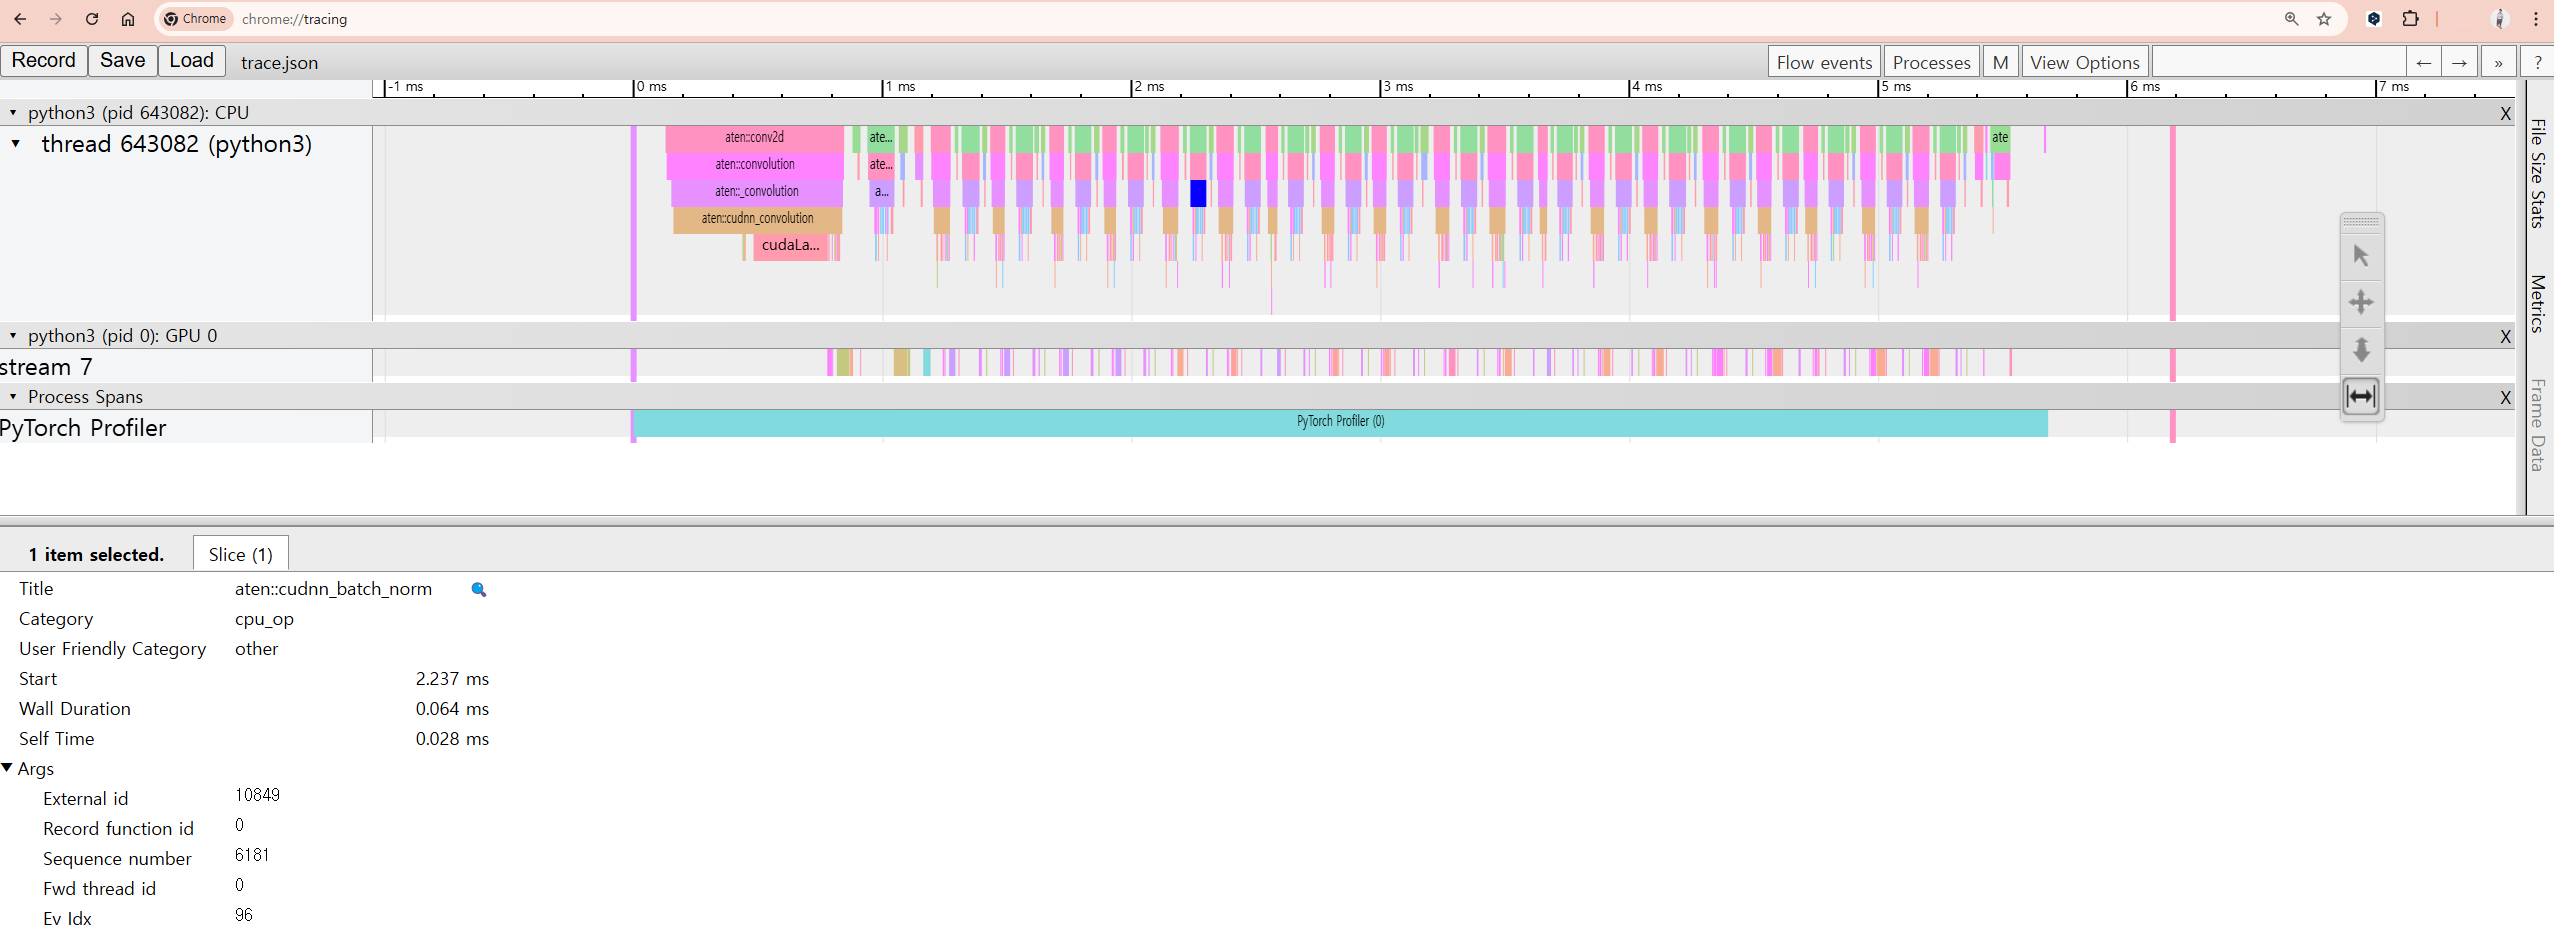

In [14]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    with_stack=True,
) as prof:
    model(inputs)

# Print aggregated stats
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cuda_time_total", row_limit=2))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        36.27%       1.987ms        50.53%       2.769ms     138.428us     782.658us        67.20%     782.658us      39.133us            20  
void cudnn::engines_precompiled::nchwToNhwcKernel<fl...         0.00%       0.000us         0.00%       0.000us       0.000us     238.494us        20.48%     238.494us       6.625us            36  
---------

In [15]:
from torch.profiler import schedule

my_schedule = schedule(
    skip_first=10,
    wait=5,
    warmup=1,
    active=3,
    repeat=2)

In [16]:
def trace_handler(p):
    output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
    print(output)
    p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        model(inputs)
        p.step()

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.00%       0.000us         0.00%       0.000us       0.000us      13.331ms       572.97%      13.331ms       6.666ms             2  
                                aten::cudnn_convolution        12.93%       1.802ms        21.80%       3.038ms      75.955us       1.561ms        67.07%       1.561ms      39.013us            40  
void cudn

## 1.3 데이터 로더(DataLoader) 속도 향상

- 주요 인자(num_workers, pin_memory, prefetch_factor)를 이용한 성능 향상  
  - num_workers: cpu 코어보다 살짝 적은 수로 세팅해 여러 코어를 최대한 활용  
  - pin_memory=True: GPU로 데이터를 더 빠르게 전송할 수 있도록 고정된 메모리 영역을 사용하며, 약간의 호스트 메모리를 더 소비      
  - prefetch_factor(torch>=1.8): 다음 배치를 미리 로드해 유휴시간을 줄임

- A100과 같은 고성능 하드웨어에서는 단순한 메모리 내 접근 및 전송이 매우 효율적이어어서, 추가적인 최적화 기법이 오히려 오버헤드로 작동할 수도 있음

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import time

# 샘플 데이터 생성
inputs = torch.randn(10000, 10)
labels = torch.randn(10000, 1)
dataset = TensorDataset(inputs, labels)

# 기본 DataLoader 성능 측정
dataloader_default = DataLoader(dataset, batch_size=64, shuffle=True)
start_time = time.time()
for _ in dataloader_default:
    pass
end_time = time.time()
time_default = end_time - start_time
print(f"기본 DataLoader 시간: {time_default:.4f} 초")

# 최적화된 DataLoader 성능 측정
dataloader_optimized = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=64, 
    pin_memory=True,
    prefetch_factor=2
)
start_time = time.time()
for _ in dataloader_optimized:
    pass
end_time = time.time()
time_optimized = end_time - start_time
print(f"최적화된 DataLoader 시간: {time_optimized:.4f} 초")

print(f"최적화된 DataLoader 사용 시 {time_default / time_optimized:.2f}배 속도 향상")

기본 DataLoader 시간: 0.0823 초
최적화된 DataLoader 시간: 1.2595 초
최적화된 DataLoader 사용 시 0.07배 속도 향상


## 1.4 정적 컴파일(Static Compilation)

- torch >= 2.0
- JIT 컴파일러를 사용해 최적화된 정적 버전으로 변환함으로써 파이썬 오버헤드를 줄여 학습 속도를 향상시킬 수 있음  
- 모델 구조와 하드웨어에 따라 성능 차이는 존재  
- 모델이 정적인 경우 가장 효과적이며, 다양한 `mode`(ex. max-autotune, reduce-overhead)를 실험해 최적의 설정을 찾아야 함

- compile에 걸리는 시간이 길기 때문에 입력 데이터의 형상(ex. 배치 사이즈)이 동적이라면(변화한다면) 이에 대해 추가적인 작업 시간이 소요될 수 있음
 - 예컨데 데이터 로더의 마지막 배치가 형상이 다를 경우, 이에 대해 추가적인 처리를 하는 과정에서 다시 새로운 컴파일 과정이 수반되며, 이로 인해 속도가 저하됨

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import os

# TF32 비활성화 (로그 메시지 피하기 및 일관된 float32 연산)
torch.backends.cuda.matmul.allow_tf32 = False # A100 등에서는 TF32가 기본일 수 있음
# 또는 성능을 위해 활성화 권장 메시지에 따라
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8:
   print("Setting float32 matmul precision to 'high'")
   torch.set_float32_matmul_precision('high')


# 간단한 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(10, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

DATA_SIZE = 10000 
BATCH_SIZE = 128
N_EPOCHS = 5     

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

inputs = torch.randn(DATA_SIZE, 10, device=device)
labels = torch.randn(DATA_SIZE, 1, device=device)
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

model = SimpleModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# --- 컴파일되지 않은 모델 ---
print("\n--- Running Uncompiled Model ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_uncompiled = end_time - start_time
print(f"컴파일되지 않은 모델 학습 시간: {time_uncompiled:.4f} 초")

# --- 'max-autotune' 컴파일된 모델 ---
print("\n--- Compiling Model (max-autotune) ---")
# 주의: 컴파일은 시간이 걸릴 수 있습니다.
compiled_model_max_autotune = torch.compile(model, mode="max-autotune")
optimizer_compiled_max = optim.Adam(compiled_model_max_autotune.parameters(), lr=0.01)

# 워밍업 실행 (컴파일 발생)
print("Running warmup for max-autotune...")
for _ in range(2): # 작은 횟수로 워밍업
    inputs_batch, labels_batch = next(iter(dataloader)) # 첫 배치로 워밍업
    optimizer_compiled_max.zero_grad()
    outputs = compiled_model_max_autotune(inputs_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer_compiled_max.step()
if device.type == 'cuda': torch.cuda.synchronize()
print("Warmup finished.")

print("--- Running Compiled Model (max-autotune, after warmup) ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer_compiled_max.zero_grad()
        outputs = compiled_model_max_autotune(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_compiled_max.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_compiled_max = end_time - start_time
print(f"'max-autotune' 컴파일된 모델 학습 시간 (워밍업 후): {time_compiled_max:.4f} 초")
if time_uncompiled > 0:
    print(f"'max-autotune' 컴파일 사용 시 (워밍업 후) {time_uncompiled / time_compiled_max:.2f}배 속도")


# --- 'reduce-overhead' 컴파일된 모델 ---
# 모델 다시 초기화 (컴파일되지 않은 상태로)
model = SimpleModel().to(device)

print("\n--- Compiling Model (reduce-overhead) ---")
compiled_model_reduce_overhead = torch.compile(model, mode="reduce-overhead")
optimizer_compiled_reduce = optim.Adam(compiled_model_reduce_overhead.parameters(), lr=0.01)

# 워밍업 실행
print("Running warmup for reduce-overhead...")
for _ in range(2): # 작은 횟수로 워밍업
    inputs_batch, labels_batch = next(iter(dataloader)) # 첫 배치로 워밍업
    optimizer_compiled_reduce.zero_grad()
    outputs = compiled_model_reduce_overhead(inputs_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer_compiled_reduce.step()
if device.type == 'cuda': torch.cuda.synchronize()
print("Warmup finished.")

print("--- Running Compiled Model (reduce-overhead, after warmup) ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer_compiled_reduce.zero_grad()
        outputs = compiled_model_reduce_overhead(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_compiled_reduce.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_compiled_reduce = end_time - start_time
print(f"'reduce-overhead' 컴파일된 모델 학습 시간 (워밍업 후): {time_compiled_reduce:.4f} 초")
if time_uncompiled > 0:
    print(f"'reduce-overhead' 컴파일 사용 시 (워밍업 후) {time_uncompiled / time_compiled_reduce:.2f}배 속도")

print("\n--- Summary (After Warmup) ---")
print(f"Uncompiled: {time_uncompiled:.4f} 초")
print(f"Compiled (max-autotune): {time_compiled_max:.4f} 초")
print(f"Compiled (reduce-overhead): {time_compiled_reduce:.4f} 초")

Setting float32 matmul precision to 'high'
Using device: cuda

--- Running Uncompiled Model ---
컴파일되지 않은 모델 학습 시간: 0.8094 초

--- Compiling Model (max-autotune) ---
Running warmup for max-autotune...
Warmup finished.
--- Running Compiled Model (max-autotune, after warmup) ---
'max-autotune' 컴파일된 모델 학습 시간 (워밍업 후): 1.7622 초
'max-autotune' 컴파일 사용 시 (워밍업 후) 0.46배 속도

--- Compiling Model (reduce-overhead) ---
Running warmup for reduce-overhead...
Warmup finished.
--- Running Compiled Model (reduce-overhead, after warmup) ---
'reduce-overhead' 컴파일된 모델 학습 시간 (워밍업 후): 1.1324 초
'reduce-overhead' 컴파일 사용 시 (워밍업 후) 0.71배 속도

--- Summary (After Warmup) ---
Uncompiled: 0.8094 초
Compiled (max-autotune): 1.7622 초
Compiled (reduce-overhead): 1.1324 초


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import os

# TF32 비활성화 (로그 메시지 피하기 및 일관된 float32 연산)
torch.backends.cuda.matmul.allow_tf32 = False # A100 등에서는 TF32가 기본일 수 있음
# 또는 성능을 위해 활성화 권장 메시지에 따라
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8:
   print("Setting float32 matmul precision to 'high'")
   torch.set_float32_matmul_precision('high')


# 간단한 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(10, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

DATA_SIZE = 10000 
BATCH_SIZE = 128
N_EPOCHS = 5    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

inputs = torch.randn(DATA_SIZE, 10, device=device)
labels = torch.randn(DATA_SIZE, 1, device=device)
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

model = SimpleModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# --- 컴파일되지 않은 모델 ---
print("\n--- Running Uncompiled Model ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_uncompiled = end_time - start_time
print(f"컴파일되지 않은 모델 학습 시간: {time_uncompiled:.4f} 초")

# --- 'max-autotune' 컴파일된 모델 ---
print("\n--- Compiling Model (max-autotune) ---")
# 주의: 컴파일은 시간이 걸릴 수 있습니다.
compiled_model_max_autotune = torch.compile(model, mode="max-autotune")
optimizer_compiled_max = optim.Adam(compiled_model_max_autotune.parameters(), lr=0.01)

# 워밍업 실행 (컴파일 발생)
print("Running warmup for max-autotune...")
for _ in range(2): # 작은 횟수로 워밍업
    inputs_batch, labels_batch = next(iter(dataloader)) # 첫 배치로 워밍업
    optimizer_compiled_max.zero_grad()
    outputs = compiled_model_max_autotune(inputs_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer_compiled_max.step()
if device.type == 'cuda': torch.cuda.synchronize()
print("Warmup finished.")

print("--- Running Compiled Model (max-autotune, after warmup) ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer_compiled_max.zero_grad()
        outputs = compiled_model_max_autotune(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_compiled_max.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_compiled_max = end_time - start_time
print(f"'max-autotune' 컴파일된 모델 학습 시간 (워밍업 후): {time_compiled_max:.4f} 초")
if time_uncompiled > 0:
    print(f"'max-autotune' 컴파일 사용 시 (워밍업 후) {time_uncompiled / time_compiled_max:.2f}배 속도")


# --- 'reduce-overhead' 컴파일된 모델 ---
# 모델 다시 초기화 (컴파일되지 않은 상태로)
model = SimpleModel().to(device)

print("\n--- Compiling Model (reduce-overhead) ---")
compiled_model_reduce_overhead = torch.compile(model, mode="reduce-overhead")
optimizer_compiled_reduce = optim.Adam(compiled_model_reduce_overhead.parameters(), lr=0.01)

# 워밍업 실행
print("Running warmup for reduce-overhead...")
for _ in range(2): # 작은 횟수로 워밍업
    inputs_batch, labels_batch = next(iter(dataloader)) # 첫 배치로 워밍업
    optimizer_compiled_reduce.zero_grad()
    outputs = compiled_model_reduce_overhead(inputs_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer_compiled_reduce.step()
if device.type == 'cuda': torch.cuda.synchronize()
print("Warmup finished.")

print("--- Running Compiled Model (reduce-overhead, after warmup) ---")
start_time = time.time()
for epoch in range(N_EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        optimizer_compiled_reduce.zero_grad()
        outputs = compiled_model_reduce_overhead(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_compiled_reduce.step()
if device.type == 'cuda': torch.cuda.synchronize() # GPU 작업 완료 기다림
end_time = time.time()
time_compiled_reduce = end_time - start_time
print(f"'reduce-overhead' 컴파일된 모델 학습 시간 (워밍업 후): {time_compiled_reduce:.4f} 초")
if time_uncompiled > 0:
    print(f"'reduce-overhead' 컴파일 사용 시 (워밍업 후) {time_uncompiled / time_compiled_reduce:.2f}배 속도")

print("\n--- Summary (After Warmup) ---")
print(f"Uncompiled: {time_uncompiled:.4f} 초")
print(f"Compiled (max-autotune): {time_compiled_max:.4f} 초")
print(f"Compiled (reduce-overhead): {time_compiled_reduce:.4f} 초")

Setting float32 matmul precision to 'high'
Using device: cuda

--- Running Uncompiled Model ---
컴파일되지 않은 모델 학습 시간: 0.7902 초

--- Compiling Model (max-autotune) ---
Running warmup for max-autotune...
Warmup finished.
--- Running Compiled Model (max-autotune, after warmup) ---
'max-autotune' 컴파일된 모델 학습 시간 (워밍업 후): 0.6803 초
'max-autotune' 컴파일 사용 시 (워밍업 후) 1.16배 속도

--- Compiling Model (reduce-overhead) ---
Running warmup for reduce-overhead...
Warmup finished.
--- Running Compiled Model (reduce-overhead, after warmup) ---
'reduce-overhead' 컴파일된 모델 학습 시간 (워밍업 후): 0.7120 초
'reduce-overhead' 컴파일 사용 시 (워밍업 후) 1.11배 속도

--- Summary (After Warmup) ---
Uncompiled: 0.7902 초
Compiled (max-autotune): 0.6803 초
Compiled (reduce-overhead): 0.7120 초


## 1.5 분산 학습(Distributed Training)

- 다중 GPU 등을 이용해 학습 속도를 향상시키는 방법
- 분산 학습은 환경설정이 복잡하고, GPU 간 통신 오버헤드가 추가적으로 발생할 수 있음.
  - 데이터 병렬 처리의 경우, 모델 크기가 충분히 크지 않다면(작을 경우) 이러한 통신 오버헤드가 성능 향상을 상쇄할 수 있음  
  (즉, 모델이 충분히 크지 않다면 굳이 분산 학습을 할 필요가 없음)
  - 분산 데이터 병렬 처리(DDP, Distributed Data Parallel)는 데이터 병렬 처리보다 더 효율적이지만,   
  별도의 초기화 과정이 필요하고 각 프로세스에서 독립적인 학습루프를 적용해야 함

### 1.5.1 단일 머신에서의 데이터 병렬 처리(Data Parallelism)
- 단일 머신에 있는 복수의 GPU에 데이터를 분산하여 병렬로 연산 수행

In [ ]:
# 작은 모델의 경우, 통신 오버헤드로 인해 속도 향상이 없거나 오히려 느려짐

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# 간단한 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        return self.linear(x)

# 가짜 데이터 생성
inputs = torch.randn(1000, 10).cuda()
labels = torch.randn(1000, 1).cuda()
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=32)

model_single_gpu = SimpleModel().cuda()
optimizer_single_gpu = optim.Adam(model_single_gpu.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 단일 GPU 학습 시간 측정
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        optimizer_single_gpu.zero_grad()
        outputs = model_single_gpu(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_single_gpu.step()
end_time = time.time()
time_single = end_time - start_time
print(f"단일 GPU 학습 시간: {time_single:.4f} 초")

# 모델 생성 및 DataParallel 적용
model_multi_gpu = SimpleModel()
if torch.cuda.device_count() > 1:
    print(f"사용 가능한 GPU 개수: {torch.cuda.device_count()}")
    model_multi_gpu = nn.DataParallel(model_multi_gpu)
model_multi_gpu.cuda()
optimizer_multi_gpu = optim.Adam(model_multi_gpu.parameters(), lr=0.01)

# 다중 GPU 학습 시간 측정
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        optimizer_multi_gpu.zero_grad()
        outputs = model_multi_gpu(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_multi_gpu.step()
end_time = time.time()
time_multi = end_time - start_time
print(f"다중 GPU 학습 시간: {time_multi:.4f} 초")

if torch.cuda.device_count() > 1:
    print(f"DataParallel 사용 시 {time_single / time_multi:.2f}배 속도 향상")

단일 GPU 학습 시간: 0.2447 초
사용 가능한 GPU 개수: 6
다중 GPU 학습 시간: 3.4013 초
DataParallel 사용 시 0.07배 속도 향상


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import os

# --- 설정값 조정 (CNN에 맞게) ---
DATA_SIZE = 20000       # 데이터 크기 (적절히 조절)
CHANNELS = 3            # 입력 채널 (예: RGB 이미지)
HEIGHT = 64             # 입력 높이
WIDTH = 64              # 입력 너비
OUTPUT_DIM = 100        # 출력 차원 (예: 클래스 개수)

# 배치 크기: GPU 메모리와 개수 고려 (6개 GPU에 분산되도록)
# 예: 6 * 128 = 768 또는 6 * 64 = 384
BATCH_SIZE = 768
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    # GPU 개수로 나누어떨어지지 않으면 경고 또는 조정
    if BATCH_SIZE % num_gpus != 0:
        print(f"경고: 배치 크기({BATCH_SIZE})가 GPU 개수({num_gpus})로 나누어떨어지지 않습니다.")
        # BATCH_SIZE = (BATCH_SIZE // num_gpus) * num_gpus # 나누어떨어지도록 조정
        # print(f"배치 크기를 {BATCH_SIZE}로 조정합니다.")

N_EPOCHS = 3            # 에포크 수 (CNN은 학습 시간이 더 김)
LEARNING_RATE = 1e-4    # 학습률 (모델이 커졌으므로 조정)

# --- 환경 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_gpus = torch.cuda.device_count()
print(f"Available GPUs: {num_gpus}")

# TF32 설정
if torch.cuda.is_available() and torch.cuda.get_device_capability(device)[0] >= 8:
   print("Setting float32 matmul precision to 'high'")
   torch.set_float32_matmul_precision('high')


# --- 더 복잡한 CNN 모델 정의 ---
class ConvModel(nn.Module):
    def __init__(self, num_classes=OUTPUT_DIM):
        super(ConvModel, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # BatchNorm 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # H, W -> H/2, W/2
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # H/2, W/2 -> H/4, W/4
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # H/4, W/4 -> H/8, W/8
        )
        # MaxPool2d 3번 적용 후 피처 맵 크기 계산
        feature_map_size = HEIGHT // (2**3)
        self.flatten = nn.Flatten()
        # Flatten 이후의 차원 계산
        flattened_dim = 256 * feature_map_size * feature_map_size
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout 추가 (과적합 방지 목적, 성능에 영향 줄 수 있음)
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x

# --- 가짜 데이터 생성 (CNN 입력 형태에 맞게 4D 텐서) ---
print("Generating CNN input dataset on GPU...")
# inputs = torch.randn(DATA_SIZE, CHANNELS, HEIGHT, WIDTH).to(device)
# labels = torch.randn(DATA_SIZE, OUTPUT_DIM).to(device) # MSELoss 사용 위해 float 형태 유지
# CPU에서 생성 후 이동
inputs_cpu = torch.randn(DATA_SIZE, CHANNELS, HEIGHT, WIDTH)
labels_cpu = torch.randn(DATA_SIZE, OUTPUT_DIM)
inputs = inputs_cpu.to(device)
labels = labels_cpu.to(device)
print("Dataset generation complete.")

dataset = TensorDataset(inputs, labels)
# drop_last=True 필수 (BatchNorm 때문, 배치 크기 1인 경우 에러 발생 가능성 있음)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"DataLoader created with batch_size={BATCH_SIZE}, drop_last=True")

# 손실 함수 정의
criterion = nn.MSELoss()

# --- 단일 GPU 학습 시간 측정 ---
print("\n--- Running Single GPU Training (CNN Model) ---")
model_single_gpu = ConvModel().to(device)
optimizer_single_gpu = optim.Adam(model_single_gpu.parameters(), lr=LEARNING_RATE)

torch.cuda.synchronize()
start_time = time.time()

model_single_gpu.train() # BatchNorm, Dropout 등을 위해 train 모드 설정
for epoch in range(N_EPOCHS):
    for i, (inputs_batch, labels_batch) in enumerate(dataloader):
        optimizer_single_gpu.zero_grad()
        outputs = model_single_gpu(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_single_gpu.step()
    # print(f"Epoch {epoch+1} completed on single GPU")

torch.cuda.synchronize()
end_time = time.time()
time_single = end_time - start_time
print(f"단일 GPU 학습 시간: {time_single:.4f} 초")


# --- 다중 GPU (DataParallel) 학습 시간 측정 ---
if num_gpus > 1:
    print(f"\n--- Running Multi GPU Training with DataParallel ({num_gpus} GPUs, CNN Model) ---")
    model_multi_gpu_base = ConvModel() # CPU에서 모델 생성
    model_multi_gpu = nn.DataParallel(model_multi_gpu_base).to(device) # 래핑 후 GPU로
    optimizer_multi_gpu = optim.Adam(model_multi_gpu.parameters(), lr=LEARNING_RATE)

    torch.cuda.synchronize()
    start_time = time.time()

    model_multi_gpu.train() # train 모드 설정
    for epoch in range(N_EPOCHS):
        for i, (inputs_batch, labels_batch) in enumerate(dataloader):
            optimizer_multi_gpu.zero_grad()
            outputs = model_multi_gpu(inputs_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer_multi_gpu.step()
        # print(f"Epoch {epoch+1} completed on multi GPU")

    torch.cuda.synchronize()
    end_time = time.time()
    time_multi = end_time - start_time
    print(f"다중 GPU (DataParallel) 학습 시간: {time_multi:.4f} 초")

    if time_single > 0:
        speedup = time_single / time_multi
        print(f"DataParallel 사용 시 {speedup:.2f}배 속도 향상")
        if speedup < 1:
            print("참고: DataParallel이 단일 GPU보다 느립니다.")
        elif speedup < num_gpus:
            print(f"참고: 속도 향상이 GPU 개수({num_gpus}x)보다 낮습니다. 이는 DataParallel의 일반적인 특징입니다.")
else:
    print("\n사용 가능한 GPU가 1개이므로 DataParallel 테스트를 건너<0xEB><0x8A>니다.")

print("\n--- 실험 완료 ---")

Using device: cuda
Available GPUs: 6
Setting float32 matmul precision to 'high'
Generating CNN input dataset on GPU...
Dataset generation complete.
DataLoader created with batch_size=768, drop_last=True

--- Running Single GPU Training (CNN Model) ---
단일 GPU 학습 시간: 3.5635 초

--- Running Multi GPU Training with DataParallel (6 GPUs, CNN Model) ---
다중 GPU (DataParallel) 학습 시간: 2.3610 초
DataParallel 사용 시 1.51배 속도 향상
참고: 속도 향상이 GPU 개수(6x)보다 낮습니다. 이는 DataParallel의 일반적인 특징입니다.

--- 실험 완료 ---


### 1.5.2 다중머신에서의 분산 데이터 병렬 처리(Distributed Data Parallel, DDP)
- `torch.distributed.DistributedDataParallel`로 구현
- 여러 GPU 또는 여러 네트워크 연결된 머신에서 효율적인 분산학습 지원
- 별도의 초기화 과정이 필요하며, 각 프로세스는 독립적인 학습 루프를 실행
- 각 프로세스에 대한 고유한 랭크와 전체 프로세스 수 설정해야하며, 네트워크 환결 설정도 중요
- 현재는 당장 구현이 어려우므로 코드는 생략

### 1.5.3 그래디언트 누적(Gradient Accumulation)
- GPU 메모리 부족으로 큰 배치 크기를 사용할 수 없을 때, 작은 배치 크기로 여러 번 순전파/역전파를 수행하고 그래디언트를 누적하여 큰 배치 크기를 모방
- 메모리 제한을 극복할 수 있지만, 학습 시간이 늘어날 수 있으며, 배치 사이즈가 줄어들었기 때문에 BatchNorm 등의 정규화 통계 계산이 불안정해질 수 있음

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import os

# --- 설정값 (CNN 모델 및 그래디언트 누적용) ---
DATA_SIZE = 10000       # 데이터 크기 (적절히 조절)
CHANNELS = 3            # 입력 채널
HEIGHT = 64             # 입력 높이
WIDTH = 64              # 입력 너비
OUTPUT_DIM = 100        # 출력 차원

PHYSICAL_BATCH_SIZE = 128 # 실제 GPU에 올라가는 배치 크기 (메모리 고려)
ACCUMULATION_STEPS = 4  # 그래디언트 누적 스텝 수
EFFECTIVE_BATCH_SIZE = PHYSICAL_BATCH_SIZE * ACCUMULATION_STEPS # 가상 배치 크기

N_EPOCHS = 2            # 에포크 수 (테스트 시간 고려)
LEARNING_RATE = 1e-4    # 학습률

# --- 환경 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_gpus = torch.cuda.device_count() # 단일 GPU 사용 가정 (누적은 보통 단일 GPU 메모리 제약 시 사용)
print(f"Available GPUs: {num_gpus}") # (참고용 출력)

# TF32 설정
if torch.cuda.is_available() and torch.cuda.get_device_capability(device)[0] >= 8:
   print("Setting float32 matmul precision to 'high'")
   torch.set_float32_matmul_precision('high')

# --- CNN 모델 정의 (이전과 동일) ---
class ConvModel(nn.Module):
    def __init__(self, num_classes=OUTPUT_DIM):
        super(ConvModel, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        feature_map_size = HEIGHT // (2**3)
        self.flatten = nn.Flatten()
        flattened_dim = 256 * feature_map_size * feature_map_size
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x

# --- 가짜 데이터 생성 (CNN 입력 형태) ---
print("Generating CNN input dataset...")
inputs_cpu = torch.randn(DATA_SIZE, CHANNELS, HEIGHT, WIDTH)
labels_cpu = torch.randn(DATA_SIZE, OUTPUT_DIM)
inputs = inputs_cpu.to(device)
labels = labels_cpu.to(device)
print("Dataset generation complete.")

dataset = TensorDataset(inputs, labels)
# 작은 물리적 배치 크기로 DataLoader 생성
dataloader = DataLoader(dataset, batch_size=PHYSICAL_BATCH_SIZE)
print(f"DataLoader created with physical batch_size={PHYSICAL_BATCH_SIZE}")
print(f"Gradient accumulation steps = {ACCUMULATION_STEPS}")
print(f"Effective batch size = {EFFECTIVE_BATCH_SIZE}")


# 손실 함수 정의
criterion = nn.MSELoss()

# --- 시나리오 1: 그래디언트 누적 없이 학습 ---
# (물리적 배치 크기 = PHYSICAL_BATCH_SIZE 로 학습)
print("\n--- Running Training WITHOUT Gradient Accumulation ---")
model = ConvModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

torch.cuda.synchronize()
start_time = time.time()

model.train()
for epoch in range(N_EPOCHS):
    for i, (inputs_batch, labels_batch) in enumerate(dataloader):
        # inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device) # 데이터 미리 GPU로 보냈음
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
    # print(f"Epoch {epoch+1} (No Accum) completed.")

torch.cuda.synchronize()
end_time = time.time()
time_no_accum = end_time - start_time
print(f"그래디언트 누적 없이 학습 시간: {time_no_accum:.4f} 초 (Physical Batch Size: {PHYSICAL_BATCH_SIZE})")


# --- 시나리오 2: 그래디언트 누적 사용 학습 ---
# (가상 배치 크기 = EFFECTIVE_BATCH_SIZE 로 학습 효과 모방)
print("\n--- Running Training WITH Gradient Accumulation ---")
model_accum = ConvModel().to(device)
optimizer_accum = optim.Adam(model_accum.parameters(), lr=LEARNING_RATE)

torch.cuda.synchronize()
start_time = time.time()

model_accum.train()
for epoch in range(N_EPOCHS):
    optimizer_accum.zero_grad() # 에포크 시작 또는 옵티마이저 스텝 이후에 zero_grad 수행
    for i, (inputs_batch, labels_batch) in enumerate(dataloader):
        # inputs_batch, labels_batch = inputs_batch.to(device, non_blocking=True), labels_batch.to(device, non_blocking=True) # 데이터 미리 GPU로 보냈음

        outputs = model_accum(inputs_batch)
        # 손실을 accumulation_steps 로 나누어 스케일링
        loss = criterion(outputs, labels_batch) / ACCUMULATION_STEPS
        # 각 미니 배치마다 그래디언트 계산 및 누적
        loss.backward()

        # accumulation_steps 마다 옵티마이저 스텝 수행 및 그래디언트 초기화
        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer_accum.step()
            optimizer_accum.zero_grad() # 여기서 그래디언트 초기화
    # 에포크가 끝나고 누적 스텝이 나누어 떨어지지 않은 경우, 남은 그래디언트로 업데이트
    # if (i + 1) % ACCUMULATION_STEPS != 0: # 루프의 마지막 i 기준
    #     optimizer_accum.step()
    #     optimizer_accum.zero_grad()
    # 위 로직은 dataloader의 총 스텝 수가 ACCUMULATION_STEPS로 나누어 떨어지지 않을 때 필요할 수 있음
    # 여기서는 단순 비교를 위해 생략 (총 스텝 = DATA_SIZE/PHYSICAL_BATCH_SIZE)
    # print(f"Epoch {epoch+1} (Accum) completed.")


torch.cuda.synchronize()
end_time = time.time()
time_accum = end_time - start_time
print(f"그래디언트 누적 사용 학습 시간: {time_accum:.4f} 초 (Effective Batch Size: {EFFECTIVE_BATCH_SIZE})")

if time_no_accum > 0:
    ratio = time_accum / time_no_accum
    print(f"\n그래디언트 누적 사용 시 학습 시간 비율: {ratio:.2f}")
    if ratio > 1:
        print("(결과 해석: 시간 비율이 1보다 큰 것이 일반적입니다. 누적 시 optimizer.step() 호출 빈도는 줄지만,")
        print(" 각 스텝 사이에 더 많은 forward/backward 연산이 수행되기 때문입니다.")
        print(" 그래디언트 누적의 주 목적은 메모리 절약 및 큰 가상 배치 크기 효과 모방이지, 동일 에포크 수 대비 시간 단축이 아닙니다.)")
    else:
        print("(결과 해석: 시간 비율이 1 이하거나 비슷하면, optimizer.step()의 오버헤드가 매우 컸거나 다른 요인이 있을 수 있습니다.)")

print("\n--- 실험 완료 ---")

Using device: cuda
Available GPUs: 6
Setting float32 matmul precision to 'high'
Generating CNN input dataset...
Dataset generation complete.
DataLoader created with physical batch_size=128
Gradient accumulation steps = 4
Effective batch size = 512

--- Running Training WITHOUT Gradient Accumulation ---
그래디언트 누적 없이 학습 시간: 1.5925 초 (Physical Batch Size: 128)

--- Running Training WITH Gradient Accumulation ---
그래디언트 누적 사용 학습 시간: 1.2688 초 (Effective Batch Size: 512)

그래디언트 누적 사용 시 학습 시간 비율: 0.80
(결과 해석: 시간 비율이 1 이하거나 비슷하면, optimizer.step()의 오버헤드가 매우 컸거나 다른 요인이 있을 수 있습니다.)

--- 실험 완료 ---


## 1.6 작업 특화 라이브러리 사용
- 딥러닝 학습 과정을 단순화하고, 최적화를 쉽게 적용할 수 있는 고수준 라이브러리를 활용

### 1.6.1 PyTorch Lightning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import time
import os

# --- 설정 ---
DATA_SIZE = 5000      # 데이터 크기 증가
INPUT_DIM = 100       # 입력 차원 증가
OUTPUT_DIM = 1        # 출력 차원
BATCH_SIZE = 128      # 배치 크기 증가
EPOCHS = 5            # 에포크 수 증가
LR = 0.001            # 학습률 조정

# --- 환경 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 모델 정의 (PyTorch & Lightning 공통 사용 가능) ---
class SimpleModel(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, output_dim=OUTPUT_DIM):
        super().__init__()
        # 약간 더 복잡하게 만들어 비교 의미 부여
        self.layer1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.layer2(x)

# --- PyTorch Lightning 모델 정의 ---
class LitModel(pl.LightningModule):
    def __init__(self, input_dim=INPUT_DIM, output_dim=OUTPUT_DIM, learning_rate=LR):
        super().__init__()
        # save_hyperparameters()를 사용하면 hparams로 접근 가능
        self.save_hyperparameters()
        self.model = SimpleModel(input_dim, output_dim) # 내부 모델로 SimpleModel 사용

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x) # 또는 self.model(x)
        loss = F.mse_loss(y_hat, y)
        # 로깅 (선택 사항, 성능 비교 시에는 최소화)
        # self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        # hparams에서 학습률 가져오기
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# --- 가짜 데이터 생성 (GPU에 미리 로드) ---
print("Generating dataset on device...")
inputs = torch.randn(DATA_SIZE, INPUT_DIM, device=device)
labels = torch.randn(DATA_SIZE, OUTPUT_DIM, device=device)
dataset = TensorDataset(inputs, labels)
# DataLoader 생성
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Dataset and DataLoader ready.")


# --- 시나리오 1: 순수 PyTorch 학습 ---
print("\n--- Running Standard PyTorch Training ---")
model_std = SimpleModel(INPUT_DIM, OUTPUT_DIM).to(device)
optimizer_std = optim.Adam(model_std.parameters(), lr=LR)
criterion = nn.MSELoss() # Lightning의 F.mse_loss와 동일

torch.cuda.synchronize() # 시작 전 동기화
start_time_std = time.time()

model_std.train()
for epoch in range(EPOCHS):
    for inputs_batch, labels_batch in dataloader:
        # 데이터는 이미 GPU에 있음
        optimizer_std.zero_grad()
        outputs = model_std(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer_std.step()
    # print(f"Epoch {epoch+1} (Standard PyTorch) completed.")

if device.type == 'cuda': torch.cuda.synchronize() # 종료 동기화
end_time_std = time.time()
time_pytorch = end_time_std - start_time_std
print(f"순수 PyTorch 학습 시간: {time_pytorch:.4f} 초")


# --- 시나리오 2: PyTorch Lightning 학습 ---
print("\n--- Running PyTorch Lightning Training ---")
model_lit = LitModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM, learning_rate=LR)

# Trainer 설정 (오버헤드 최소화를 위해 로깅, 체크포인트, 프로그레스 바 비활성화)
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator='gpu' if device.type == 'cuda' else 'cpu',
    devices=1, # 단일 장치 사용 명시
    enable_checkpointing=False, # 체크포인트 저장 안 함
    logger=False,              # 로거 사용 안 함
    enable_progress_bar=False, # 프로그레스 바 끄기
    enable_model_summary=False # 모델 요약 출력 안 함
)

torch.cuda.synchronize() # 시작 전 동기화 (Trainer 내부에서도 처리하지만 명시)
start_time_lit = time.time()

trainer.fit(model_lit, dataloader)

# Lightning Trainer는 내부적으로 동기화를 수행할 수 있음
# 좀 더 확실한 측정을 위해 필요 시 추가 동기화
# if device.type == 'cuda': torch.cuda.synchronize()
end_time_lit = time.time()
time_lightning = end_time_lit - start_time_lit
print(f"PyTorch Lightning 학습 시간: {time_lightning:.4f} 초")


# --- 결과 비교 ---
print("\n--- Comparison ---")
print(f"Standard PyTorch Time: {time_pytorch:.4f} s")
print(f"PyTorch Lightning Time: {time_lightning:.4f} s")
if time_pytorch > 0:
    ratio = time_lightning / time_pytorch
    print(f"Lightning Time / Standard PyTorch Time: {ratio:.2f}")
    if ratio > 1:
        print("(결과 해석: Lightning은 프레임워크 오버헤드로 인해 단순 작업에서는 약간 더 느릴 수 있습니다.)")
        print("           하지만 코드 구조화, 재현성, 확장성 등에서 큰 이점을 제공합니다.")
    else:
        print("(결과 해석: Lightning이 비슷하거나 더 빠릅니다. 내부 최적화가 효과적이거나 PyTorch 루프에 비효율이 있을 수 있습니다.)")

Using device: cuda
Generating dataset on device...
Dataset and DataLoader ready.

--- Running Standard PyTorch Training ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


순수 PyTorch 학습 시간: 0.5139 초

--- Running PyTorch Lightning Training ---


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=5` reached.


PyTorch Lightning 학습 시간: 0.4936 초

--- Comparison ---
Standard PyTorch Time: 0.5139 s
PyTorch Lightning Time: 0.4936 s
Lightning Time / Standard PyTorch Time: 0.96
(결과 해석: Lightning이 비슷하거나 더 빠릅니다. 내부 최적화가 효과적이거나 PyTorch 루프에 비효율이 있을 수 있습니다.)


### 1.6.2 NVIDIA Apex
- Apex는 더이상 활발하게 유지보수되지 않고 있으며, PyTorch의 torch.amp 기능으로 대부분의 기능을 대체 가능함
- NVIDIA GPU 환경에서 혼합 정밀도 학습을 더 세밀하게 하고 싶을 경우에만 사용 권장

In [2]:
# from apex import amp # Apex 설치 필요
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import time

# # 간단한 모델 정의
# class SimpleModel(nn.Module):
#     def __init__(self):
#         super(SimpleModel, self).__init__()
#         self.linear = nn.Linear(10, 1)

#     def forward(self, x):
#         return self.linear(x)

# # 가짜 데이터 생성
# inputs = torch.randn(1000, 10).cuda()
# labels = torch.randn(1000, 1).cuda()
# dataset = TensorDataset(inputs, labels)
# dataloader = DataLoader(dataset, batch_size=32)

# model = SimpleModel().cuda()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.MSELoss()

# # Apex 사용 전 학습 시간 측정
# start_time = time.time()
# for epoch in range(3):
#     for inputs, labels in dataloader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
# end_time = time.time()
# time_before_apex = end_time - start_time
# print(f"Apex 사용 전 학습 시간: {time_before_apex:.4f} 초")

# # Apex 초기화 및 학습 시간 측정
# model_apex = SimpleModel().cuda()
# optimizer_apex = optim.Adam(model_apex.parameters(), lr=0.01)
# model_apex, optimizer_apex = amp.initialize(model_apex, optimizer_apex, opt_level="O1")

# start_time = time.time()
# for epoch in range(3):
#     for inputs, labels in dataloader:
#         optimizer_apex.zero_grad()
#         outputs = model_apex(inputs)
#         loss = criterion(outputs, labels)
#         with amp.scale_loss(loss, optimizer_apex) as scaled_loss:
#             scaled_loss.backward()
#         optimizer_apex.step()
# end_time = time.time()
# time_after_apex = end_time - start_time
# print(f"Apex 사용 후 학습 시간: {time_after_apex:.4f} 초")

# print(f"Apex 사용 시 {time_before_apex / time_after_apex:.2f}배 속도 향상")

### 1.6.3 Microsoft DeepSpeed
- 큰 모델 학습을 위한 메모리 효율성과 속도 최적화에 특화된 라이브러리로, ZeRO와 같은 기술을 통해 메모리 사용량을 줄이고 성능을 향상시킴
- 그러나 복잡한 사전설정 및 모델 구조가 DeepSpeed와 호환되어야 함

In [3]:
# import deepspeed # DeepSpeed 설치 필요
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import time
#
# # 간단한 모델 정의
# class SimpleModel(nn.Module):
#     def __init__(self):
#         super(SimpleModel, self).__init__()
#         self.linear = nn.Linear(10, 1)
#
#     def forward(self, x):
#         return self.linear(x)
#
# # 가짜 데이터 생성
# inputs = torch.randn(1000, 10).cuda()
# labels = torch.randn(1000, 1).cuda()
# dataset = TensorDataset(inputs, labels)
# dataloader = DataLoader(dataset, batch_size=32)
#
# model = SimpleModel().cuda()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.MSELoss()
#
# # DeepSpeed 사용 전 학습 시간 측정
# start_time = time.time()
# for epoch in range(3):
#     for inputs, labels in dataloader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
# end_time = time.time()
# time_before_deepspeed = end_time - start_time
# print(f"DeepSpeed 사용 전 학습 시간: {time_before_deepspeed:.4f} 초")
#
# # DeepSpeed 초기화 및 학습 시간 측정
# model_deepspeed = SimpleModel().cuda()
# optimizer_deepspeed = optim.Adam(model_deepspeed.parameters(), lr=0.01)
#
# model_engine, optimizer_deepspeed, _, _ = deepspeed.initialize(
#     model=model_deepspeed,
#     optimizer=optimizer_deepspeed,
#     model_parameters=model_deepspeed.parameters()
# )
#
# start_time = time.time()
# for epoch in range(3):
#     for inputs, labels in dataloader:
#         inputs = inputs.cuda()
#         labels = labels.cuda()
#         outputs = model_engine(inputs)
#         loss = criterion(outputs, labels)
#         model_engine.backward(loss)
#         model_engine.step()
# end_time = time.time()
# time_after_deepspeed = end_time - start_time
# print(f"DeepSpeed 사용 후 학습 시간: {time_after_deepspeed:.4f} 초")
#
# print(f"DeepSpeed 사용 시 {time_before_deepspeed / time_after_deepspeed:.2f}배 속도 향상")

## 1.7 모델 특화 최적화
- 모델 구조나 학습 방식 자체를 변경해 학습 속도를 높이는 방법

### 1.7.1 사전 학습된 모델 FineTuning

- 사전학습된 모델의 가중치를 불러와 해당 가중치로 초기값을 설정해 학습 epoch를 단축가능함으로써 학습 효율 증대 가능

### 1.7.2 가지치기(Pruning) 및 양자화(Quantization)을 통한 모델 크기 축소
- 모델의 중요하지 않은 연결이나 가중치를 제거(가지치기)하거나, 가중치와 활성화 함수의 정밀도를 낮춰(양자화) 모델 크기를 줄이고 연산 속도를 높임
  - 가지치기와 양자화 모두, 모델의 정확도와 같은 성능을 감소시킬 수 있음
  - 특히 가지치기의 경우, 희소 행렬 연산에 대한 하드웨어 지원이 필요할 수 있음

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import torch.nn.utils.prune as prune
import torch.quantization
import copy # 모델 복사를 위해 추가

# --- 환경 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")
print(f"Using device for main tests: {device}")
print(f"Using device for quantization test: {cpu_device}")

# TF32 설정 (해당되는 경우)
if torch.cuda.is_available() and torch.cuda.get_device_capability(device)[0] >= 8:
   print("Setting float32 matmul precision to 'high'")
   torch.set_float32_matmul_precision('high')

# --- Helper Function for Inference Timing ---
def time_inference(model, dummy_input, num_runs=100, device=device):
    """주어진 모델과 입력으로 추론 시간을 측정하는 함수"""
    model.to(device)
    dummy_input = dummy_input.to(device)
    model.eval() # 추론 모드 설정

    # 워밍업 실행
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # 시간 측정
    torch.cuda.synchronize(device) if device.type == 'cuda' else None
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
    torch.cuda.synchronize(device) if device.type == 'cuda' else None
    end_time = time.time()

    avg_time_ms = (end_time - start_time) / num_runs * 1000
    return avg_time_ms

# 비교를 위한 더미 입력 데이터 생성
BATCH_SIZE_SIMPLE = 64
INPUT_DIM_SIMPLE = 1024 # 이전 예제보다 약간 크게
dummy_input_simple = torch.randn(BATCH_SIZE_SIMPLE, INPUT_DIM_SIMPLE)

# 모델 정의 (더 많은 파라미터를 갖도록 약간 수정)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(INPUT_DIM_SIMPLE, 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, 10) # 출력 10으로 가정

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# --- GPU 추론 비교 (Original vs Pruned) ---
if device.type == 'cuda':
    print("\n[GPU Inference]")
    # 시나리오 2-1: 원본 모델 (GPU)
    model_original_gpu = SimpleModel()
    time_original_gpu = time_inference(model_original_gpu, dummy_input_simple, device=device)
    print(f"Original Model (GPU) Inference Time: {time_original_gpu:.4f} ms per batch")

    # 시나리오 2-2: 가지치기된 모델 (GPU)
    model_pruned_gpu = SimpleModel()
    # 가지치기 적용 (Linear1 레이어의 50% 가중치 제거)
    prune.random_unstructured(model_pruned_gpu.linear1, name="weight", amount=0.5)
    prune.remove(model_pruned_gpu.linear1, 'weight') # 가지치기 마스크를 영구 적용
    time_pruned_gpu = time_inference(model_pruned_gpu, dummy_input_simple, device=device)
    print(f"Pruned Model (GPU) Inference Time:  {time_pruned_gpu:.4f} ms per batch")

    if time_original_gpu > 0:
        ratio_prune_gpu = time_pruned_gpu / time_original_gpu
        print(f"Pruned / Original (GPU) Inference Time Ratio: {ratio_prune_gpu:.2f}")
        print("(해석: 비정형 가지치기는 GPU에서 속도 향상이 거의 없거나 약간의 오버헤드가 있을 수 있습니다.)")
else:
    print("\nGPU not available, skipping GPU pruning comparison.")


# --- CPU 추론 비교 (Original vs Pruned vs Quantized) ---
print("\n[CPU Inference]")
# 시나리오 2-3: 원본 모델 (CPU)
model_original_cpu = SimpleModel()
time_original_cpu = time_inference(model_original_cpu, dummy_input_simple, device=cpu_device)
print(f"Original Model (CPU) Inference Time: {time_original_cpu:.4f} ms per batch")

# 시나리오 2-4: 가지치기된 모델 (CPU)
model_pruned_cpu = SimpleModel()
prune.random_unstructured(model_pruned_cpu.linear1, name="weight", amount=0.5)
prune.remove(model_pruned_cpu.linear1, 'weight')
time_pruned_cpu = time_inference(model_pruned_cpu, dummy_input_simple, device=cpu_device)
print(f"Pruned Model (CPU) Inference Time:  {time_pruned_cpu:.4f} ms per batch")

# 시나리오 2-5: 동적 양자화된 모델 (CPU)
# 양자화는 원본 모델의 복사본에 적용하는 것이 좋음
model_to_quantize = SimpleModel()
model_to_quantize.eval() # 양자화 전에 eval 모드 필수
# 동적 양자화 적용 (Linear 레이어만 대상)
quantized_model_dynamic = torch.quantization.quantize_dynamic(
    model_to_quantize, {torch.nn.Linear}, dtype=torch.qint8
)
time_quantized_cpu = time_inference(quantized_model_dynamic, dummy_input_simple, device=cpu_device)
print(f"Quantized Model (CPU) Inference Time: {time_quantized_cpu:.4f} ms per batch")


# CPU 결과 비교
print("\nCPU Inference Ratios:")
if time_original_cpu > 0:
    ratio_prune_cpu = time_pruned_cpu / time_original_cpu
    ratio_quant_cpu = time_quantized_cpu / time_original_cpu
    print(f"  Pruned / Original (CPU): {ratio_prune_cpu:.2f}")
    print(f"  Quantized / Original (CPU): {ratio_quant_cpu:.2f}")
    print("(해석: 비정형 가지치기는 CPU에서도 속도 향상이 미미할 수 있습니다.")
    print("        동적 양자화는 일반적으로 CPU에서 상당한 속도 향상을 보입니다.)")

print("\n--- 실험 완료 ---")

Using device for main tests: cuda
Using device for quantization test: cpu
Setting float32 matmul precision to 'high'

[GPU Inference]
Original Model (GPU) Inference Time: 0.0609 ms per batch
Pruned Model (GPU) Inference Time:  0.0615 ms per batch
Pruned / Original (GPU) Inference Time Ratio: 1.01
(해석: 비정형 가지치기는 GPU에서 속도 향상이 거의 없거나 약간의 오버헤드가 있을 수 있습니다.)

[CPU Inference]
Original Model (CPU) Inference Time: 0.2395 ms per batch
Pruned Model (CPU) Inference Time:  0.2417 ms per batch
Quantized Model (CPU) Inference Time: 0.3146 ms per batch

CPU Inference Ratios:
  Pruned / Original (CPU): 1.01
  Quantized / Original (CPU): 1.31
(해석: 비정형 가지치기는 CPU에서도 속도 향상이 미미할 수 있습니다.
        동적 양자화는 일반적으로 CPU에서 상당한 속도 향상을 보입니다.)

--- 실험 완료 ---


## 1.8 cuDNN 및 GPU 설정

- 입력 크기가 고정돼 있다면 `benchmark` 모드를 활성화해 최적의 커널을 선택하도록 함으로써 약간의 성능 이득을 볼 수 있음
  - 반대로 입력 크기가 자주 변한다면 오히려 안좋음
- `deterministic` 옵션이 경우 재현 가능한 결과물을 얻기 위해 사용되나, 약간의 성능 저하가 있을 수 있음
  - `non_block=True`로 설정하면 cpu와 gpu 간의 데이터 전송을 비동기적으로 수행해 GPU가 유휴 상태가 되는 시간을 줄여줌

In [3]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 간단한 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        return self.linear(x)

# 가짜 데이터 생성
inputs = torch.randn(1000, 10)
labels = torch.randn(1000, 1)
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=32, drop_last=True)
model = SimpleModel().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# cuDNN benchmark 비활성화 시 학습 시간 측정
torch.backends.cudnn.benchmark = False
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end_time = time.time()
time_no_benchmark = end_time - start_time
print(f"cuDNN benchmark 비활성화 시 학습 시간: {time_no_benchmark:.4f} 초")

# cuDNN benchmark 활성화 시 학습 시간 측정
torch.backends.cudnn.benchmark = True
start_time = time.time()
for epoch in range(3):
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end_time = time.time()
time_benchmark = end_time - start_time
print(f"cuDNN benchmark 활성화 시 학습 시간: {time_benchmark:.4f} 초")

print(f"cuDNN benchmark 활성화 시 {time_no_benchmark / time_benchmark:.2f}배 속도 향상")

cuDNN benchmark 비활성화 시 학습 시간: 0.2400 초
cuDNN benchmark 활성화 시 학습 시간: 0.0703 초
cuDNN benchmark 활성화 시 3.41배 속도 향상


# 2. 메모리 사용량 최적화 기법